In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pybnesian as pbn
from util_draw import *
# from util_metrics import *
from util_syntethic import *
import time 

### SIMULATE DATA


In [2]:
config = get_config(1)
print(len(config['arcs']), 'arcs for key 2')
ref_model0 = pbn.SemiparametricBN(**config)
draw_model(ref_model0,'synthetic1', save=False)

config = get_config(2)
ref_model0 = pbn.SemiparametricBN(**config)
draw_model(ref_model0,'synthetic2', save=False)
print(len(config['arcs']), 'arcs for key 13')


config = get_config(3)
ref_model0 = pbn.SemiparametricBN(**config)
draw_model(ref_model0,'synthetic3', save=False)
print(len(config['arcs']), 'arcs for key 3')

config = get_config(4)
ref_model0 = pbn.SemiparametricBN(**config)
draw_model(ref_model0,'synthetic4', save=False)
print(len(config['arcs']), 'arcs for key 4')



10 arcs for key 2
21 arcs for key 13
7 arcs for key 3
14 arcs for key 4


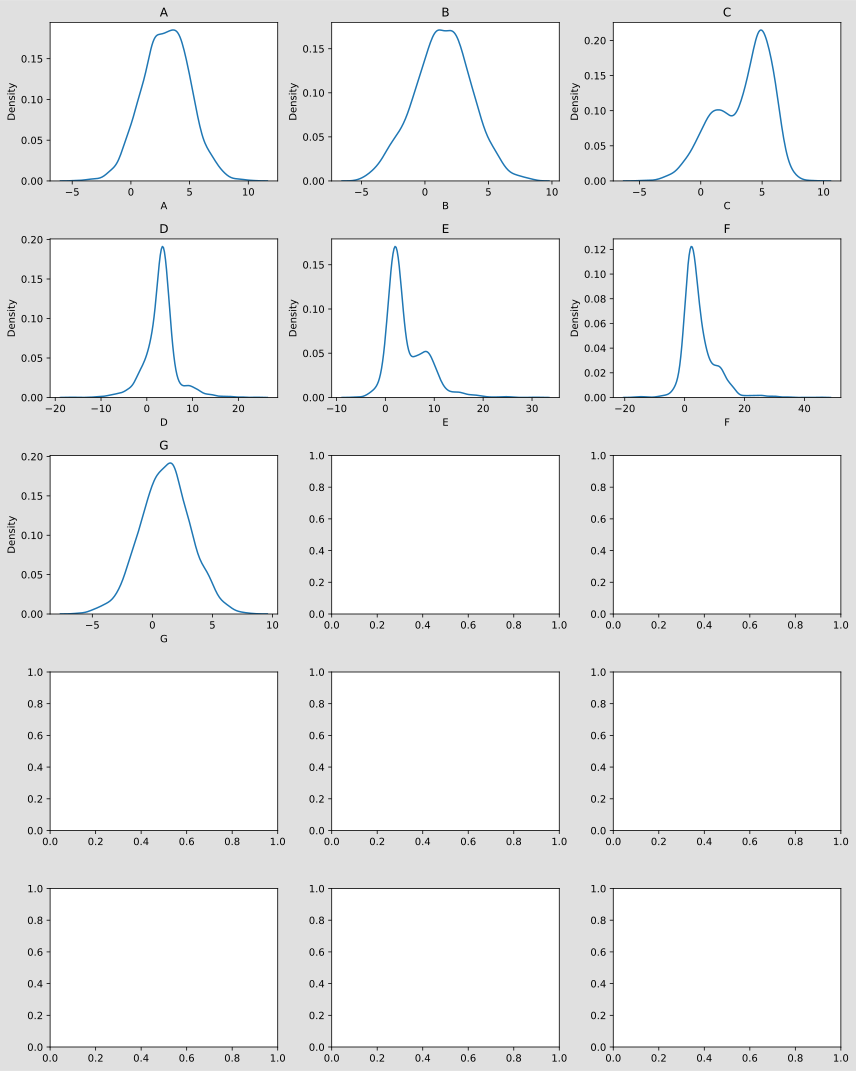

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pybnesian as pbn
from util_draw import *
from util_metrics import *
#from util_syntethic import *
import time 

key = 1
data = generate_data(key,2000,seed=20)
config = get_config(key)


nodemap = {node: i for i, node in enumerate(data.columns.values)}

fig, axs = plt.subplots(5, 3, figsize=(12, 15))
for i, col in enumerate(data.columns):
    sns.kdeplot(data[col], ax=axs[i // 3, i % 3])
    axs[i // 3, i % 3].set_title(col)


plt.tight_layout()
plt.show()

ref_model0 = pbn.SemiparametricBN(nodes = list(data.columns.values), **config)
# fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# plot_model(ref_model0,ax)

In [4]:
ntrain, ntest = 2**12, 2**11 
print(ntrain, ntest)



4096 2048


In [7]:
executions = []
for i in range(5):
    
    train = generate_data(key, ntrain, seed=0)
    test = generate_data(key, ntest, seed=255)
    hc = pbn.GreedyHillClimbing()
    vl = pbn.ValidatedLikelihood(train, k=5)
    pool = pbn.OperatorPool([pbn.ArcOperatorSet(), pbn.ChangeNodeTypeSet()])

    ref_model0.fit(train)
    logl_ref = ref_model0.logl(test)

    emptynet = pbn.SemiparametricBN(list(data.columns.values))
    start = time.time()
    model = hc.estimate(pool, vl, emptynet, patience = 3, max_indegree = 3)
    end = time.time()
    train_time = end - start
    
    model.fit(train)
    
    start = time.time()
    logl_pred = model.logl(test)
    end = time.time()
    test_time = end - start

    print((np.sum(logl_pred), np.sum(logl_ref)))


    hmd = hamming_distance(model.arcs(), config['arcs'], nodemap)
    shd = structural_hamming_distance(model.arcs(), config['arcs'])
    thmd = node_type_hamming_distance(model.node_types(), ref_model0.node_types())
    rmse = np.sqrt(np.mean((logl_pred - logl_ref)**2))
    relative_err = np.mean(np.abs(logl_pred - logl_ref) / np.abs(logl_ref))*100
    executions.append(pd.DataFrame({'HMD': hmd, 'SHD': shd, 'THMD':thmd, 'rmse':rmse, 'relative_err':relative_err,'train time':train_time, 'test_time': test_time}, index=[i]))
    print(executions[-1])

    missingarcs = [arcs for arcs in model.arcs() if arcs not in config['arcs']]
    badnode = [node for node in model.node_types().items() if node not in ref_model0.node_types().items()]
    print(missingarcs)
    print(badnode)
df_spbn = pd.concat(executions)
df_spbn

(-30203.57289996689, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
0  0.0    1     0  0.000223      0.000889   23.714371   0.520016
[('B', 'A')]
[]
(-30203.573644309658, -30203.573644309658)
   HMD  SHD  THMD          rmse  relative_err  train time  test_time
1  0.0    0     0  1.009174e-15  2.534937e-15   24.414369   0.494403
[]
[]
(-30203.57289996689, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
2  0.0    1     0  0.000223      0.000889   22.842782   0.517442
[('B', 'A')]
[]
(-30203.57289996689, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
3  0.0    1     0  0.000223      0.000889   24.601596   0.629772
[('B', 'A')]
[]
(-30206.24336229924, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
4  1.0    2     0  0.021424      0.073388   22.989071   0.597233
[('D', 'G'), ('B', 'A')]
[]


,HMD,SHD,THMD,rmse,relative_err,train time,test_time
0,0.0,1,0,2.226030e-04,8.890301e-04,23.714371,0.520016
1,0.0,0,0,1.009174e-15,2.534937e-15,24.414369,0.494403
2,0.0,1,0,2.226030e-04,8.890301e-04,22.842782,0.517442
3,0.0,1,0,2.226030e-04,8.890301e-04,24.601596,0.629772
4,1.0,2,0,2.142422e-02,7.338833e-02,22.989071,0.597233


In [8]:
mean_spbn = df_spbn.mean().to_frame().T
mean_spbn

,HMD,SHD,THMD,rmse,relative_err,train time,test_time
0,0.2,1.0,0.0,0.004418,0.015211,23.712438,0.551773


In [11]:
grid = 50
linear = False
fft = True
fit_fbn = dict(grid=grid, linear=linear, use_fft=fft)
executions = []
for i in range(5):
    train = generate_data(key, ntrain, seed=0)
    test = generate_data(key, ntest, seed=255)
    
    hc = pbn.GreedyHillClimbing()
    # vl = pbn.CVLikelihoodFT(train, k=10,
    #                     grid_size=grid, linear_binning=False, use_fft=False)

    vl = pbn.ValidatedLikelihoodFT(train, k=5,
                                   **fit_fbn)

    pool = pbn.OperatorPool([pbn.ArcOperatorSet(), pbn.ChangeNodeTypeSet()])
    
    ref_model0.fit(train)
    logl_ref = ref_model0.logl(test)
    
    emptynet = pbn.BinnedSPBN(list(data.columns.values))
    start = time.time()
    model = hc.estimate(pool, vl, emptynet, patience = 3, max_indegree = 3)
    end = time.time()
    train_time = end - start
    
    model.fit(train,**fit_fbn)
    
    start = time.time()
    logl_pred = model.logl(test)
    end = time.time()
    test_time = end - start

    print((np.sum(logl_pred), np.sum(logl_ref)))
    
    hmd = hamming_distance(model.arcs(), config['arcs'], nodemap)
    shd = structural_hamming_distance(model.arcs(), config['arcs'])
    thmd = node_type_hamming_distance(model.node_types(), ref_model0.node_types())
    rmse = np.sqrt(np.mean((logl_pred - logl_ref)**2))
    relative_err = np.mean(np.abs(logl_pred - logl_ref) / np.abs(logl_ref))*100
    executions.append(pd.DataFrame({'HMD': hmd, 'SHD': shd, 'THMD':thmd, 'rmse':rmse, 'relative_err':relative_err,'train time':train_time, 'test_time': test_time}, index=[i]))

    print(executions[-1])
    
    missingarcs = [arcs for arcs in model.arcs() if arcs not in config['arcs']]
    badnode = [node for node in model.node_types().items() if node not in ref_model0.node_types().items()]
    print(missingarcs)
    print(badnode)

df_fsbn = pd.concat(executions)
df_fsbn

(-30265.38417209309, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
0  0.0    0     0  0.133434      0.440748   17.763081   0.380271
[]
[('F', FBKernelType), ('E', FBKernelType), ('D', FBKernelType), ('C', FBKernelType)]
(-30265.383427750323, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
1  0.0    1     0  0.133415      0.440769   17.722056   0.382645
[('B', 'A')]
[('F', FBKernelType), ('E', FBKernelType), ('D', FBKernelType), ('C', FBKernelType)]
(-30265.383427750323, -30203.573644309658)
   HMD  SHD  THMD      rmse  relative_err  train time  test_time
2  0.0    1     0  0.133415      0.440769   17.140538   0.386249
[('B', 'A')]
[('F', FBKernelType), ('E', FBKernelType), ('D', FBKernelType), ('C', FBKernelType)]
(-30268.053890082672, -30203.573644309658)
   HMD  SHD  THMD     rmse  relative_err  train time  test_time
3  1.0    2     0  0.13497       0.45307   16.705125   0.346325
[('D', 'G'), ('B', 'A')]
[(

,HMD,SHD,THMD,rmse,relative_err,train time,test_time
0,0.0,0,0,0.133434,0.440748,17.763081,0.380271
1,0.0,1,0,0.133415,0.440769,17.722056,0.382645
2,0.0,1,0,0.133415,0.440769,17.140538,0.386249
3,1.0,2,0,0.134970,0.453070,16.705125,0.346325
4,0.0,0,0,0.133434,0.440748,16.388748,0.340745


In [12]:
mean_fsbn = df_fsbn.mean().to_frame().T
mean_fsbn

,HMD,SHD,THMD,rmse,relative_err,train time,test_time
0,0.2,0.8,0.0,0.133734,0.443221,17.14391,0.367247


## PUBLIC DATASETS 

### NASA BENCHMARKS
https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

Read the matlab and txt files, and store the information in CSV format

#### CMAPSS 

In [86]:
def read_data(path):
  df = pd.read_csv(path, delimiter=' ', header=None)
  # check null ratios of each columns
  rc = df.isnull().sum(axis=0)/len(df)
  print(rc[rc!=0.])
  return df

names = ['unit', 'time',
         'altitude', 'mach', 'TRA',
         'T2', 'T24', 'T30', 'T50', 'P2', 'P15', 'P30', 'Nf', 'Nc', 'epr',
         'Ps30', 'phi', 'NRf', 'NRc', 'BPR', 'farB', 'htBleed', 'Nf_dmd', 'PCNfR_dmd', 'W31', 'W32']

df_train1 = read_data('data/aingura/public_datasets/train_FD001.txt')
df_train2 = read_data('data/aingura/public_datasets/train_FD002.txt')
df_train3 = read_data('data/aingura/public_datasets/train_FD003.txt')
df_train4 = read_data('data/aingura/public_datasets/train_FD004.txt')
# remove full of null columns
df_train1.drop([26, 27], axis=1, inplace=True)
df_train1.columns = names
df_train2.drop([26, 27], axis=1, inplace=True)
df_train2.columns = names
df_train3.drop([26, 27], axis=1, inplace=True)
df_train3.columns = names
df_train4.drop([26, 27], axis=1, inplace=True)
df_train4.columns = names


FileNotFoundError: [Errno 2] No such file or directory: 'data/aingura/public_datasets/train_FD001.txt'

In [ ]:
df_trains_sealvl = pd.concat([df_train1, df_train3],axis=0).reset_index(drop=True)
df_trains_sealvl.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_trains_sealvl.csv', index=False)
df_trains_sealvl

In [ ]:
df_trains_six = pd.concat([df_train2, df_train4],axis=0).reset_index(drop=True)
df_trains_six.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_trains_six.csv', index=False)
df_trains_six

In [ ]:
df_test1 = read_data('data/aingura/public_datasets/test_FD001.txt')
df_test2 = read_data('data/aingura/public_datasets/test_FD002.txt')
df_test3 = read_data('data/aingura/public_datasets/test_FD003.txt')
df_test4 = read_data('data/aingura/public_datasets/test_FD004.txt')

# remove full of null columns
df_test1.drop([26, 27], axis=1, inplace=True)
df_test1.columns = names
df_test2.drop([26, 27], axis=1, inplace=True)
df_test2.columns = names
df_test3.drop([26, 27], axis=1, inplace=True)
df_test3.columns = names
df_test4.drop([26, 27], axis=1, inplace=True)
df_test4.columns = names

In [ ]:
df_test_sealvl = pd.concat([df_test1, df_test3], axis=0).reset_index(drop=True)
df_test_sealvl.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_tests_sealvl.csv', index=False)
df_test_sealvl

In [ ]:
df_test_six = pd.concat([df_test2, df_test4], axis=0).reset_index(drop=True)
df_test_six.to_csv('data/aingura/public_datasets/nasa_repos/6_cmapss_tests_six.csv', index=False)
df_test_six

In [ ]:
for n in names:
    print(n, df_test_six[n].nunique(), df_test_sealvl[n].nunique())
    print(n, df_trains_six[n].nunique(), df_trains_sealvl[n].nunique())



#### IGBT data 

In [ ]:
from scipy.io import loadmat

# Replace 'your_file.mat' with the path to your MATLAB file
mat_data = loadmat('data/aingura/IGBTAgingData_04022009/IGBTAgingData_04022009/Data/Thermal Overstress Aging with DC at gate/20080429T135531.mat')

mat_data.keys()



In [130]:
names = ['GATE_VOLTAGE', 'COLLECTOR_VOLTAGE', 'HEAT_SINK_TEMP', 'GATE_CURRENT', 'COLLECTOR_CURRENT', 'TIME', 'PACKAGE_TEMP']

vars = {}
for n in names:
    vars[n] = mat_data[n].flatten()

df = pd.DataFrame(vars)
df.to_csv('data/aingura/nasa_repos/8.igbt-the_thermal_overstress_aging_with_dc_at_gate.csv', index=False)

#### milling

In [81]:
from scipy.io import loadmat
import pandas as pd


In [88]:
mat_data = loadmat('data/aingura/nasa_repos/3. Milling/mill.mat',simplify_cells=True)

mill = mat_data['mill']
pandas_df = []
for i in range(len(mill)):
    df = pd.DataFrame(mill[i])
    pandas_df.append(df)
pandas_df = pd.concat(pandas_df, axis=0)
pandas_df.to_csv('data/aingura/nasa_repos/3_mill.csv', index=False)


### PREPARE NASA CSVs 
Read the CSVs and prepare them (drop datestamps, identifiers, etc.)

In [48]:
data3 = pd.read_csv('../data/public_datasets/nasa_repos/3/3_mill.csv')
data6_1 = pd.read_csv('../data/public_datasets/nasa_repos/6/6_cmapss_trains_six.csv')
data6_2 = pd.read_csv('../data/public_datasets/nasa_repos/6/6_cmapss_tests_sealvl.csv')
data8 = pd.read_csv('../data/public_datasets/nasa_repos/8/8_igbt-thermal_overstress_aging_with_dc_at_gate.csv')

In [49]:
drop3 = ['case','run']
drop6 = ['unit','time']
drop8 = ['TIME']
drops = drop3+drop6+drop8
names = ['6_3_mill', '7_6_cmapss_trains_six', '8_8_igbt-thermal_overstress_aging_with_dc_at_gate']
for n,data in enumerate([data3, data6_1, data8]):
    data = data.dropna()
    value_counts = {col:data[col].unique().shape[0] for col in data.columns}
    more_than = {k:v for k,v in value_counts.items() if v > 0}
    data_more_than = data[more_than.keys()]
    columns = data_more_than.columns
    col_drops = [col for col in columns if col not in drops]
    data_ready = data_more_than[col_drops]
    data_ready = data_ready.astype(float)
    # discrete_columns = [col for col in data_ready.columns if data_ready[col].unique().shape[0] < 10]
    # if len(discrete_columns) > 0:
    #     print({col:data_ready[col].unique().shape for col in data_ready.columns if data_ready[col].unique().shape[0] < 10})
    #     data_ready = data_ready.drop(discrete_columns, axis=1)
    
    save = f'../data/public_datasets/both_ready/{names[n]}.csv'
    data_ready.to_csv(save, index=False)
    # print('\n',more_than)
    # print(data_ready.info())
    # print(data_ready.head(10).to_string())


### UCI REPOSITORY
https://archive.ics.uci.edu/datasets?FeatureTypes=Numerical&Python=true&skip=0&take=10&sort=desc&orderBy=NumHits&search=

Download the datasets from UCI repository


In [9]:
from ucimlrepo import fetch_ucirepo 

savepath = 'data/aingura/uci_repos/'

In [ ]:
# fetch dataset 
individual_household_electric_power_consumption = fetch_ucirepo(id=235) 
  
# data (as pandas dataframes) 
X = individual_household_electric_power_consumption.data.features 
y = individual_household_electric_power_consumption.data.targets 
  
X
# X.to_csv(savepath+'individual_household_electric_power_consumption.csv', index=False)

In [ ]:
individual_household_electric_power_consumption.metadata

In [21]:
# fetch dataset 
appliances_energy_prediction = fetch_ucirepo(id=374) 
  
# data (as pandas dataframes) 
X = appliances_energy_prediction.data.features 
y = appliances_energy_prediction.data.targets 

X
# X.to_csv(savepath+'appliances_energy_prediction.csv', index=False)

In [ ]:
appliances_energy_prediction.metadata

In [26]:
# fetch dataset 
magic_gamma_telescope = fetch_ucirepo(id=159) 
  
# data (as pandas dataframes) 
X = magic_gamma_telescope.data.features 
y = magic_gamma_telescope.data.targets 

X
# X.to_csv(savepath+'magic_gamma_telescope.csv', index=False)

In [ ]:
magic_gamma_telescope.metadata

In [37]:
# fetch dataset 
single_elder_home_monitoring_gas_and_position = fetch_ucirepo(id=799) 
  
# data (as pandas dataframes) 
X = single_elder_home_monitoring_gas_and_position.data.features 
y = single_elder_home_monitoring_gas_and_position.data.targets 

X
X.to_csv(savepath+'single_elder_home_monitoring_gas_and_position.csv', index=False)

In [ ]:
single_elder_home_monitoring_gas_and_position.metadata

In [41]:
# fetch dataset 
htru2 = fetch_ucirepo(id=372) 
  
# data (as pandas dataframes) 
X = htru2.data.features 
y = htru2.data.targets 

X
# X.to_csv(savepath+'htru2.csv', index=False)

In [ ]:
htru2.metadata

### PREPARE UCI CSVs
Read the CSVs and prepare them (drop datestamps, identifiers, etc.)

In [42]:
data1 = pd.read_csv('../data/public_datasets/uci_repos/1_appliances_energy_prediction.csv')
data2 = pd.read_csv('../data/public_datasets/uci_repos/2_htru2.csv')
data3 = pd.read_csv('../data/public_datasets/uci_repos/3_individual_household_electric_power_consumption.csv')
data4 = pd.read_csv('../data/public_datasets/uci_repos/4_magic_gamma_telescope.csv')
data6 = pd.read_csv('../data/public_datasets/uci_repos/6_single_elder_home_monitoring_gas_and_position.csv')

/tmp/ipykernel_12442/1869481806.py:3: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data3 = pd.read_csv('../data/public_datasets/uci_repos/3_individual_household_electric_power_consumption.csv')


In [43]:
drop1 = ['date','rv1','rv2']
drop3 = ['Date','Time']
drop5 = ['date']
drop6 = ['timestamp']

names = ['1_appliances_energy_prediction', '2_htru2', '3_individual_household_electric_power_consumption', '4_magic_gamma_telescope', '6_single_elder_home_monitoring_gas_and_position']

drops = drop1+drop3+drop5+drop6
for n, data in enumerate([data1]): #data2, data3, data4, data6]):
    data = data.dropna()
    value_counts = {col:data[col].unique().shape[0] for col in data.columns}
    more_than = {k:v for k,v in value_counts.items() if v > 0}
    data_more_than = data[more_than.keys()]
    columns = data_more_than.columns
    col_drops = [col for col in columns if col not in drops]
    data_ready = data_more_than[col_drops]
    data_ready = data_ready.astype(float)
    discrete_columns = [col for col in data_ready.columns if data_ready[col].unique().shape[0] < 10]
    if len(discrete_columns) > 0:
        print({col:data_ready[col].unique().shape for col in data_ready.columns if data_ready[col].unique().shape[0] < 10})
        data_ready = data_ready.drop(discrete_columns, axis=1)

    save = f'../data/public_datasets/both_ready/{names[n]}.csv'
    data_ready.to_csv(save, index=False)

    

{'lights': (8,)}


In [47]:
import glob 
datas = glob.glob('../data/public_datasets/both_ready/*.csv')
for path in datas:
    data = pd.read_csv(path)
    print(data.head(5).to_string())

    fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  fM3Trans   fAlpha     fDist
0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   -8.2027  40.0920   81.8828
1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   -9.9574   6.3609  205.2610
2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580  -45.2160  76.9600  256.7880
3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   -7.1513  10.4490  116.7370
4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   21.8393   4.6480  356.4620
   Global_active_power  Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3
0                4.216                  0.418   234.84              18.4             0.0             1.0            17.0
1                5.360                  0.436   233.63              23.0             0.0             1.0            16.0
2                5.374                  0.498   233.29              23.0 